<a href="https://colab.research.google.com/github/souzajvp/data_science_bootcamp/blob/main/modulo_final/Jo%C3%A3o_V%C3%ADtor_Perez_de_Souza_Projeto_final_24_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Capa](https://raw.githubusercontent.com/souzajvp/data_science_bootcamp/main/modulo_final/Prancheta%205.png)

# Um pouco sobre mim:

Meu nome é João Vítor Perez de Souza, sou biomédico e atualmente aluno de doutorado na Universidade Estadual de Maringá-Paraná. Sempre tive gosto pela área de bioinformática, e mais recentemente comecei a aprender sobre programação, ciência de dados e etc. 
***
### Onde encontrar meu trabalho?
1. [ResearchGate](https://www.researchgate.net/profile/Joao_Souza34);
2. [Github](https://github.com/souzajvp) - em construção;
3. [LinkedIn](https://www.linkedin.com/in/jo%C3%A3o-v%C3%ADtor-perez-de-souza/)

## Guia para o notebook:
<font color='Gray'> >> </font> Textos precedidos de sinais na cor <font color='Gray'> Cinza </font> são comentários gerais feitos por mim. <br>
<font color='Red'> >> </font> Textos precedidos de sinais na cor <font color='Red'> Vermelha </font> são questionamentos que tentarei responder. <br>
<font color='Blue'> >> </font> Textos precedidos de sinais na cor <font color='Blue'> Azul </font> são respostas e hipóteses levantadas por mim para responder aos questionamentos anteriores.

# Funções e imports

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
from collections import ChainMap
from sklearn.metrics import (plot_confusion_matrix, roc_auc_score, plot_roc_curve, auc, 
                             accuracy_score, recall_score, f1_score)

from sklearn.model_selection import (cross_validate, StratifiedKFold, RepeatedStratifiedKFold, 
                                     train_test_split, GridSearchCV, RandomizedSearchCV)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings('ignore')

%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)

Populating the interactive namespace from numpy and matplotlib


## Funções

In [2]:
def testa_e_retorna_pacientes_nulos(dados: pd.DataFrame):
    """
    Função que retorna a lista de ids dos pacientes e nomes de colunas que tem dados nulos em todas as 
    linhas antes de entratrem na UTI.
    """    
    colunas = []
    pacientes = []
    for i in dados['PATIENT_VISIT_IDENTIFIER'].unique():
        dataframe = (dados.query('PATIENT_VISIT_IDENTIFIER == @i and ICU == 0'))
        for index, value in dataframe.isna().sum().items():
            if value == len(dataframe):
              colunas.append(index)
              pacientes.append(i)
                
    pacientes_com_nulos = list(set(pacientes))
    colunas_com_nulos = list(set(colunas))          
    
    return colunas_com_nulos, pacientes_com_nulos

In [3]:
def preenche_tabela(dataframe: pd.DataFrame):
    '''
    Função que processa os dados nulos de acordo com as recomendações do Sírio Libânes, 
    preenchendo-os com valores posteriores e anteriores. Funciona através de uma estratégia
    de tratamento dos dados nulos individual, uma vez que não podemos executar o 
    preenchimento da mesma forma para todas as variáveis.
    ## Variáveis de saída:
    dataframe.iloc[:, -2:] - WINDOW  e ICU
    ## Variáveis categóricas:
    dataframe.iloc[:, :13]
    ## Variáveis contínuas:
    dataframe.iloc[:, 13:-2].columns
    #### Créditos
    Função desenvolvida pelo Guilherme Silveira durante as aulas do módulo 05, com pequenas modificações. 

    '''
    features_continuas_colunas = dataframe.iloc[:, 13:-2].columns
    features_continuas = (dataframe.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False)[features_continuas_colunas].
                        fillna(method='ffill').fillna(method='bfill'))
    features_categoricas = dataframe.iloc[:, :13]
    saida = dataframe.iloc[:, -2:]
    dataframe_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,
                         axis=1)
    dataframe_finais.columns = dataframe.columns
    return dataframe_finais

In [4]:
def remove_e_mantem_min_icu(rows):
    '''
    Função criada para manipular os dataframe de forma atenda aos seguintes critérios:
    1. Não podemos utilizar dados de pacientes que estão na UTI (ICU==1)
        Para atender essa necessidade, primeiro checo se alguma das linhas tem 
        ICU==1. Caso True, removo todas as linhas com ICU==1
    2. Temos que usar dados com ICU=1 e ICU=0.
        Para isso, atribuo o valor de 1 para a primeira linha dos pacientes que 
        tinham algum valor de ICU=1. Caso o paciente não tenha nenhum ICU==1,
        apenas a primeira linha é mantida, continuando com ICU==0.
    ##### Uso:
    Essa função foi criada para uso conjunto com o método apply, seguido de um groupby
    usando a variável "PATIENT_VISIT_IDENTIFIER".
    ##### Créditos:
    Função criada pelo Guilherme Silveira durante as aulas do módulo 05, com nome
    diferente (original = prepare_window(rows)). 
    '''
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']== '0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW']== '0-2']

In [5]:
def remove_e_mantem_max_icu(rows):
    '''
    Função criada para manipular os dataframe de forma atenda aos seguintes critérios:
    1. Não podemos utilizar dados de pacientes que estão na UTI (ICU==1)
        Para atender essa necessidade, primeiro checo se alguma das linhas tem 
        ICU==1. Caso True, removo todas as linhas com ICU==1
    2. Temos que usar o máximo de dados possíveis para treinar o modelo e temos que 
    fornecer exemplos que pacientes que foram e não foram para ICU.
        Para isso, atribuo o valor de 1 para a última linha dos dados dos pacientes
        que tinham algum valor de ICU=1. Desta forma, classifico os últimos dados
        disponíveis para treinamento como os dados de uma pessoa que irá para a UTI.
    ##### Uso:
    Essa função foi criada para uso conjunto com o método apply, seguido de um groupby
    usando a variável "PATIENT_VISIT_IDENTIFIER".
    ##### Créditos:
    Função inspirada pela função "prepare_window(rows)" criada pelo 
    Guilherme Silveira durante as aulas do módulo 05
    '''
    if(np.any(rows['ICU'])):
        for i in rows['ICU'].index:
            if rows.loc[i, 'ICU'] == 1:
                rows = rows.drop(i)
        rows.iloc[-1, -1] = 1
    return rows

In [6]:
def retorna_colunas_expandidas(dataframe: pd.DataFrame):
    """
    Função que retorna listas das múltiplas versões de cada variável
    """
    colunas_diff_rel = dataframe.columns[dataframe.columns.str[-3:] == 'REL'].to_list()
    colunas_diff     = dataframe.columns[dataframe.columns.str[-4:] == 'DIFF'].to_list()
    colunas_min      = dataframe.columns[dataframe.columns.str[-3:] == 'MIN'].to_list()    
    colunas_max      = dataframe.columns[dataframe.columns.str[-3:] == 'MAX'].to_list()
    colunas_median   = dataframe.columns[dataframe.columns.str[-6:] == 'MEDIAN'].to_list()
    colunas_mean     = dataframe.columns[dataframe.columns.str[-4:] == 'MEAN'].to_list()
    
    return colunas_mean, colunas_median, colunas_max, colunas_min, colunas_diff, colunas_diff_rel

def avalia_correlacao_unica_spearman(dataframe: pd.DataFrame):
    '''
    Função criada para lidar com a característica única do dataset onde existem de 5 a 6 colunas
    derivadas do mesmo indicador. Ex. SODIUM_MEAN, SODIUM_MAX, SODIUM_MEDIAN, etc.

    Essa função faz uso da função --> retorna_colunas_expandidas(dataframe) para selecionar
    as colunas que contém cada um dos termos e em seguida calcula qual das versões de cada
    termo tem a maior correlação de Spearman com a variávl de interesse.

    *** Importante: A variável é selecionada de acordo com sua correlação absoluta!

    Além disso, também retorna a lista de variáveis a a serem descartadas.
    '''
    c_mean, c_median, c_max, c_min, c_diff, c_diff_rel = retorna_colunas_expandidas(dataframe)
    correlacao_unica = []
    for i in range(len(c_min)):
        variaveis = [c_min[i], c_mean[i], c_max[i], c_median[i], c_diff[i], 'ICU_EVER']
        correlacao_unica.append(abs(dataframe[variaveis].corrwith(dataframe['ICU_EVER'], method='spearman').drop('ICU_EVER')).idxmax())
  
    all_c = c_mean + c_median + c_max + c_min + c_diff
    var_descartadas = [i for i in all_c if i not in correlacao_unica]

    return correlacao_unica, var_descartadas


In [7]:
def plota_graficos_correlacao(y1: str, cor1: float, y2: str, cor2: float,
                              y3: str, cor3: float, y4: str, cor4: float,
                             hue_var: str, dados: pd.DataFrame):
    
    """
    Função para plotar os gráficos de linha para acompanhar a variação dos marcadores perante 
    os dois grupos de pacientes.
    """
    
    fig, ax = plt.subplots(2,2, figsize=(16,8), sharex=True)

    sns.lineplot(data=dados, x='WINDOW', y=y1, hue= hue_var, ax=ax[0,0])
    ax[0,0].set_title(f'{y1} - {cor1}', weight='bold')
    handles, labels = ax[0,0].get_legend_handles_labels()
    ax[0,0].legend(handles, ['Não', 'Sim'], title='Alguma vez ICU')  

    sns.lineplot(data=dados, x='WINDOW', y=y2, hue= hue_var, ax=ax[0,1])
    ax[0,1].set_title(f'{y2} - {cor2}', weight='bold')
    handles, labels = ax[0,0].get_legend_handles_labels()
    ax[0,1].legend(handles, ['Não', 'Sim'], title='Alguma vez ICU')   
    
    sns.lineplot(data=dados, x='WINDOW', y=y3, hue= hue_var, ax=ax[1,0])
    ax[1,0].set_title(f'{y3} - {cor3}', weight='bold')
    handles, labels = ax[0,0].get_legend_handles_labels()
    ax[1,0].legend(handles, ['Não', 'Sim'], title='Alguma vez ICU') 

    sns.lineplot(data=dados, x='WINDOW', y=y4, hue= hue_var, ax=ax[1,1])
    ax[1,1].set_title(f'{y4} - {cor4}', weight='bold')
    handles, labels = ax[0,0].get_legend_handles_labels()
    ax[1,1].legend(handles, ['Não', 'Sim'], title='Alguma vez ICU')
    
    fig.savefig('Correlação.png', dpi=150, bbox_inches='tight')
    

In [8]:

def roda_modelos_selecao_unica(dados: pd.DataFrame, n: int):
    """
    Função criada para executar triagem de diversos modelos classificatórios perante os dados.
    ###Passo a passo da função:
    1. Aleatorizo a organização do dataframe;
    2. Determino quais serão as variáveis X e variável Y;
    3. Instancio os modelos;
    4. Para cada modelo, executo um número de testes:
       a) separo os dados de treino e teste;
       b) faço o fit dos dados;
       c) coleto a métrica AUC para cada iteração;
       d) retorno a média e o intervalo de confiança da AUC de cada modelo;
    5. Por fim, retorno um dataframe contendo o nome de cada modelo e as métricas obitidas, organizdas
       do melhor resultado para  o pior.
    """
    dados = dados.sample(frac=1).reset_index(drop=True)
    y = dados['ICU']
    x = dados.drop(['ICU', 'WINDOW'], axis=1)
    
    modelo_dummy =          DummyClassifier()
    modelo_logit =          LogisticRegression(max_iter=10000)
    modelo_arvore =         DecisionTreeClassifier()
    modelo_random_forest =  RandomForestClassifier(n_estimators=100)
    modelo_gradient_boost = GradientBoostingClassifier(n_estimators=100)
  
    lista_modelos = [modelo_dummy, modelo_logit, modelo_arvore, modelo_random_forest, modelo_gradient_boost]
    nome_modelos = ['DummyRegressor', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier',
                    'GradientBoostingClassifier']
    
    
    df = pd.DataFrame(columns=['Modelo', f'AUC_Mean{n}', f'IC_Min{n}', f'IC_Max{n}'])
    lines = []
    for modelo in range(len(lista_modelos)):
        auc_lista = []
        for _ in range(n):
            x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)
            lista_modelos[modelo].fit(x_train, y_train)
            prob_predict = lista_modelos[modelo].predict_proba(x_test)
            auc = roc_auc_score(y_test, prob_predict[:,1])
            auc_lista.append(auc)
        auc_medio = np.mean(auc_lista)
        auc_std = np.std(auc_lista)
        lines.append([nome_modelos[modelo], auc_medio, auc_medio - 2* auc_std, auc_medio + 2* auc_std])
    for i in range(len(lines)):
        df.loc[i] = lines[i]
    
    return df.sort_values(f'AUC_Mean{n}', ascending=False).reset_index(drop=True)


def roda_modelos_selecao_unica_aleatoria(dados: pd.DataFrame, n: int):
    """
    Função muito similar à roda_modelos_selecao_unica(), com a peculariedade de
    remover 84 pacientes que nunca foram para a UTI de forma aleatória antes de 
    testar e treinar os modelos.
    """
    dados = dados.sample(frac=1).reset_index(drop=True)
    pct_id = dados.query('ICU ==0')['PATIENT_VISIT_IDENTIFIER'].tolist()
    remover = sample(pct_id, 84)
    
    dados = dados.query('PATIENT_VISIT_IDENTIFIER not in @remover')
    y = dados['ICU']
    x = dados.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
    
    modelo_dummy =          DummyClassifier()
    modelo_logit =          LogisticRegression(max_iter=10000)
    modelo_arvore =         DecisionTreeClassifier()
    modelo_random_forest =  RandomForestClassifier(n_estimators=100)
    # modelo_extra_reg =      ExtraTreesRegressor(n_estimators=100)
    modelo_gradient_boost = GradientBoostingClassifier(n_estimators=100)
  
    lista_modelos = [modelo_dummy, modelo_logit, modelo_arvore, modelo_random_forest, modelo_gradient_boost]
    nome_modelos = ['DummyRegressor', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier',
                    'GradientBoostingClassifier']
    
    
    df = pd.DataFrame(columns=['Modelo', f'AUC_Mean{n}', f'IC_Min{n}', f'IC_Max{n}'])
    lines = []
    
    for modelo in range(len(lista_modelos)):
        auc_lista = []
        for _ in range(n):
            x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y)
            lista_modelos[modelo].fit(x_train, y_train)
            prob_predict = lista_modelos[modelo].predict_proba(x_test)
            auc = roc_auc_score(y_test, prob_predict[:,1])
            auc_lista.append(auc)
        auc_medio = np.mean(auc_lista)
        auc_std = np.std(auc_lista)
        lines.append([nome_modelos[modelo], auc_medio, auc_medio - 2* auc_std, auc_medio + 2* auc_std])
    for i in range(len(lines)):
        df.loc[i] = lines[i]
    
    return df.sort_values(f'AUC_Mean{n}', ascending=False).reset_index(drop=True)

In [9]:
def remove_corr_var(dados: pd.DataFrame, valor_corte: int):
    """
    Função que analiza a correlação de pearson entre as variáveis do banco de dados.
    Cria uma matriz aplicando uma máscara para remover os dados espelhados.
    Retorna os dados já sem as variáveis com correlação maior que o valor de corte
    """
    matrix_corr = dados.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k =1).astype(np.bool))
    excluir = [coluna for coluna in  matrix_upper.columns if any(matrix_upper[coluna] > valor_corte)]
    
    return dados.drop(excluir, axis=1)

In [10]:
def roda_modelo_cv(modelo, dados: pd.DataFrame, n_splits: int, n_repeats: int):
    """
    Função que executa validação cruzada de um certo modelo com um número de divisões
    nos dados e um número de repetições nos testes.
    ### Parâmetros:
    modelo   --> Modelo a ser avaliado;
    dados    --> Pandas dataframe que contém os dados a serem avaliados;
    n_splits --> Número de fragmentações feitas nos dados para treino e teste;
    n_repeats -> Número de repetições em que o processo será realizado
    ### Passo a passo da função:
    1. Aleatoriza a organização do dataframe;
    2. Determina quais serão as variáveis X e variável Y;
    3. Executa o processo de validação cruzada com os parâmetros n_splits e n_repeats;
    4. Retorna o modelo utilizado, a média de AUC e o intervalo de confiança da AUC
    """
  
    np.random.seed(321351654)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados['ICU']
    x = dados.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
    
   
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc')


    auc_medio = np.mean(resultados['test_score'])
    auc_std= np.std(resultados['test_score'])
    
    return modelo, auc_medio, (auc_medio - (2*auc_std)), (auc_medio + (2*auc_std))

def roda_cross_validate_modelos(modelos: list, dados: pd.DataFrame, n_splits: int, n_repeats: int):
    """
    Função que automatiza o processo de validação cruzada, permitindo a avaliação
    de diversos modelos dentro de uma lista.
    
    Retorna um dataframe contendo as informações e métricas de cada modelo.
    """
    scores = []
    for i in modelos:
        modelo, auc_medio, ic_auc_min, ic_auc_max = roda_modelo_cv(i, dados, n_splits, n_repeats)
        scores.append([modelo, auc_medio, ic_auc_min, ic_auc_max])
    return pd.DataFrame(data=scores, columns=['Modelo',f'AUC_Mean', 'IC_Min', 'IC_Max'])


In [11]:
def roda_modelo_cv_min_max(modelo, dados: pd.DataFrame, n_splits: int, n_repeats: int):
    """
    Função muito semelhante à função roda_modelo_cv(), com pequenas modificações para
    ser usada com o dataframe de pacientes fictícios 
    """
  
    np.random.seed(321351654)
    dados = dados.sample(frac=1).reset_index(drop=True)
    x_columns = dados.columns
    y = dados['ICU_EVER']
    x = dados.drop(['ICU', 'ICU_EVER', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
    
   
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    resultados = cross_validate(modelo, x, y, cv=cv, scoring='roc_auc')


    auc_medio = np.mean(resultados['test_score'])
    auc_std= np.std(resultados['test_score'])
    
    return modelo, auc_medio, (auc_medio - (2*auc_std)), (auc_medio + (2*auc_std))

def roda_cross_validate_modelos_min_max(modelos: list, dados: pd.DataFrame, n_splits: int, n_repeats: int):
    """
    Função que automatiza o processo de validação cruzada, permitindo a avaliação
    de diversos modelos dentro de uma lista.
    
    Retorna um dataframe contendo as informações e métricas de cada modelo.
    """
    scores = []
    for i in modelos:
        modelo, auc_medio, ic_auc_min, ic_auc_max = roda_modelo_cv_min_max(i, dados, n_splits, n_repeats)
        scores.append([modelo, auc_medio, ic_auc_min, ic_auc_max])
    return pd.DataFrame(data=scores, columns=['Modelo',f'AUC_Mean', 'IC_Min', 'IC_Max'])


In [12]:
def gera_max_min(dados: pd.DataFrame):
    """
    Função que gera um novo dataframe contendo as versões máximas e mínimas para cada paciente.
    """
    maximo = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False).max()
    minimo = dados.groupby('PATIENT_VISIT_IDENTIFIER', as_index=False).min()
    
    dataframe = pd.concat([maximo, minimo])
    
    return dataframe.sort_values('PATIENT_VISIT_IDENTIFIER')

def estratifica_max_min(dados_lim: pd.DataFrame, dados_max: pd.DataFrame, razao_train_test: int):
    """
    Função que busca separar de forma estratificada os pacientes que irão para treino e teste, garantindo
    que as versões de cada paciente não estejam nos dois conjuntos ao mesmo tempo.
    """
    
    dataframe_expandido = gera_max_min(dados_max)   

    # Lista de pacientes ICU = 1: estratificação da var y para teste.
    alguma_uti_id = (dados_lim[dados_lim['ICU'] == 1]
                     ['PATIENT_VISIT_IDENTIFIER'].unique().tolist())
    estratificar_alguma_uti = sample(alguma_uti_id, int(len(alguma_uti_id)/razao_train_test))
    
    # Lista de pacientes ICU = 0: estratificação da var y para teste
    nunca_uti_id = (dados_lim[dados_lim['ICU'] == 0]
                    ['PATIENT_VISIT_IDENTIFIER'].unique().tolist())
    estratificar_nunca_uti = sample(nunca_uti_id, int(len(nunca_uti_id)/razao_train_test))    
    
    return dataframe_expandido, estratificar_alguma_uti, estratificar_nunca_uti

def train_test_split_stratified_manual_max_min(dados_lim: pd.DataFrame, dados_max, razao_train_test):
    """
    Função que separa os conjuntos de treino e teste de forma estratificada e treina o modelo, retornando
    as métricas de interesse.
    """
    df_balanceado, strat_uti, strat_nunca_uti = estratifica_max_min(dados_lim, dados_max, razao_train_test)
    
    # Juntando as duas listas que contém a proporção adequada de pacientes que foram e não para a UTI
    lista_ids_teste = strat_uti + strat_nunca_uti
    
    # Conjuntos de treino não devem ter os ids presentes em 'estratificar_alguma_uti'
    treino = df_balanceado.query('PATIENT_VISIT_IDENTIFIER not in @lista_ids_teste')
    x_train = treino.drop(['PATIENT_VISIT_IDENTIFIER', 'ICU', 'ICU_EVER', 'WINDOW'], axis=1)
    y_train = treino['ICU_EVER']
    
    # Conjuntos de teste devem conter apenas os ids presentes em 'estratificar_alguma_uti'
    teste = df_balanceado.query('PATIENT_VISIT_IDENTIFIER in @lista_ids_teste')
    x_test = teste.drop(['PATIENT_VISIT_IDENTIFIER', 'ICU', 'ICU_EVER', 'WINDOW'], axis=1)
    y_test = teste['ICU_EVER']

    modelo_random_forest = modelo_random_forest_param_extra
    modelo_random_forest.fit(x_train, y_train)
    
    previsao = modelo_random_forest.predict(x_test)
    recall = recall_score(y_test, previsao)
    
    prob_predict = modelo_random_forest.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predict[:,1])
    
    f1 = f1_score(y_test, previsao)
    precision = accuracy_score(y_test, previsao)

    
    return auc, recall, f1, precision

def testa_n_vezes_max_min(n_repeats: int, razao_train_test: int):
    """
    Função que executa o processo de separação de treino e teste estratificada dos dados um certo número de vezes
    """
    scores = []
    for _ in range(n_repeats):
        auc, recall, f1, precision = train_test_split_stratified_manual_max_min(limitados, maximizados, razao_train_test)
        scores.append([auc, recall, f1, precision])
    colunas = [f'AUC_Média{n_repeats}', f'Recall_Médio{n_repeats}',
               f'F1_Médio{n_repeats}', f'Precision_Médio{n_repeats}']
    dataframe = pd.DataFrame(columns=colunas,data=scores)
    return pd.DataFrame(columns=colunas, data=[dataframe.mean()])

def train_test_split_stratified_manual_max_min_reais(dados_lim: pd.DataFrame, dados_max, razao_train_test):
    """
    Função que separa os conjuntos de treino e teste de forma estratificada e treina o modelo, retornando
    as métricas de interesse. Desenvolvida para treinar o modelo randomforest com os dados max e min e 
    testar com pacientes reais deixados de fora, usando apenas a primeira janela deles.
    """
    df_balanceado, strat_uti, strat_nunca_uti = estratifica_max_min(dados_lim, dados_max, razao_train_test)
    
    # Juntando as duas listas que contém a proporção adequada de pacientes que foram e não para a UTI
    lista_ids_teste = strat_uti + strat_nunca_uti
    
    # Conjuntos de treino não devem ter os ids presentes em 'estratificar_alguma_uti'
    treino = df_balanceado.query('PATIENT_VISIT_IDENTIFIER not in @lista_ids_teste')
    x_train = treino.drop(['PATIENT_VISIT_IDENTIFIER', 'ICU', 'ICU_EVER', 'WINDOW'], axis=1)
    
    y_train = treino['ICU_EVER']
    
    # Conjuntos de teste devem conter apenas os ids presentes em 'estratificar_alguma_uti'
    treino_columns = treino.drop('ICU_EVER', axis=1).columns
    teste = limitados.query('PATIENT_VISIT_IDENTIFIER in @lista_ids_teste')
    x_test = teste.drop(['PATIENT_VISIT_IDENTIFIER', 'ICU', 'WINDOW'], axis=1)
    y_test = teste['ICU']

    modelo_random_forest = modelo_random_forest_param_extra   
    modelo_random_forest.fit(x_train, y_train)
    
    previsao = modelo_random_forest.predict(x_test)
    recall = recall_score(y_test, previsao)
    
    prob_predict = modelo_random_forest.predict_proba(x_test)
    auc = roc_auc_score(y_test, prob_predict[:,1])
    
    f1 = f1_score(y_test, previsao)
    precision = accuracy_score(y_test, previsao)

    
    return auc, recall, f1, precision, modelo_random_forest, x_test, y_test


def testa_n_vezes_max_min_reais(n_repeats, razao_train_test):
    """
    Roda o processo de treino com dados max_min e teste com dados reais da janela 0-2 diversas vezes e 
    retorna métricas médias de todos os testes.
    """
    scores = []
    for _ in range(n_repeats):
        auc, recall, f1, precision, modelo_random_forest, x_test, y_test= train_test_split_stratified_manual_max_min_reais(limitados, maximizados, razao_train_test)
        scores.append([auc, recall, f1, precision])
    colunas = [f'AUC_Média{n_repeats}', f'Recall_Médio{n_repeats}',
               f'F1_Médio{n_repeats}', f'Precision_Médio{n_repeats}']
    dataframe = pd.DataFrame(columns=colunas,data=scores)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    
    plot_confusion_matrix(modelo_random_forest, x_test, y_test, ax= ax, cmap='Blues')
    ax.set_title('Matriz de confusão: \n modelo RandomForest', y=-0.4, fontsize=16)
    ax.set_ylabel('Classificação verdadeira', fontsize=12)
    ax.set_xlabel('Classificação predita', fontsize=12)
    
    return pd.DataFrame(columns=colunas, data=[dataframe.mean()])

# Projeto final


## **Resumo das etapas do projeto**
1. **Tratamento dos dados**:

Os dados brutos foram avaliados, buscando entender qual era a frequência de dados faltantes na base e a distribuição deles nos pacientes. Foram identificados 58 pacientes que não se encaixavam dentro das diretrizes do desafio. Após remoção destes, os dados nulos restantes foram preenchidos com técnicas de preenchimento para frente (*forwardfill*) e para trás (*backfill*). Por fim, uma nova variável foi criada (`ICU_EVER`), para facilitar o agrupamento dos pacientes em grupos.

2. **Seleção de variáveis para treinamento**:

Foi feita remoção de variáveis redudantes e seleção das que tinham maior correlação com a variável de estudo.

3. **Bancos utilizados no treinamento dos modelos**:

Com a conclusão das etapas anteriores, foram preparados dois bancos:
* dados_limitados: conjunto que representa os dados de apenas a primeira janela de cada paciente;
* dados_maximizados: conjunto contendo o máximo de dados de cada paciente. Posteriormente transformado em um banco de pacientes fictícios, usando valores máximos e mínimos de cada paciente.
***
![Graphical Abstract](https://raw.githubusercontent.com/souzajvp/data_science_bootcamp/main/modulo_final/graphical-abstract-bootcamp.png)
Créditos da figura: [Letícia Sayuri Murase](https://www.researchgate.net/profile/Leticia-Murase)

**Links e referência**:
* [Dataset Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19);

## Problema
Classificar os pacientes internados com COVID-19 no hospital Sírio Libanês (Brasília-DF e São Paulo-SP) de acordo com a necessidade ou não as instalações das Unidades de Terapia Intensiva (UTIs). <br>

### Objetivos/Tarefas:
1. Prever quais pacientes necessitarão de UTI;
2. Prever quais pacientes NÃO necessitarão de UTI.

### Variável de interesse e Janela: 
* UTI ou não - `ICU` - (0,1);
* Janela de tempo - `WINDOW` - ['0-2', '2-4', '6-12', 'Above-12');
    
### Critérios obrigatórios
Não se pode utilizar os dados quando o paciente deu entrada na UTI -> `ICU = 1`
    
### Aspectos dos dados
Os dados foram **anonimizados e escalados** para manterem-se entre 0 e 1 de acordo com valores máximos e mínimos;

### Entendendo as variáveis disponíveis:
***
* Informações demgráficas (03);
* Agrupamento de doenças (09);
* Resultados de exames de sangue (36);
* Sinais vitais (06). <br>

Diversas variáveis foram expandidas para versões `média`, `mediana`, `máximo`, `mínimo`, `diff` e `diff relativo`.
* diff = `valor máximo` - `valor mínimo`;
* diff relativo = `diff` / `mediana`

### Entendendo a estrutura dos dados:
***
Neste desafio, temos dados de pacientes positivos para COVID-19 internados no Hospital Sírio Libânes de São Paulo-SP e Brasília-DF. De forma geral, temos até 5 entradas que representam dados de um mesmo paciente. Essas entradas são referentes à diferentes janelas de tempo (`0-2, 2-4, 4-6, 6-12, >12`) em que os pacientes foram acompanhados. Para cada uma das janelas, foram dosados diversos marcadores biológicos e sinais vitais. <br>
Resumidamente, a estrutura do banco é a seguinte:

**Tabela 1. Estrutura de repetição dos dados no banco usado no desafio.**

| **Paciente** | **Janela** | **Exame_1** | **Exame_2** | ... | **UTI** |
|:------------:|:----------:|:-----------:|:-----------:|-----|:-------:|
|       A      |     0-2    |      1      |      4      | ... |    0    |
|       A      |     2-4    |      1      |     3.5     | ... |    0    |
|       A      |     4-6    |     1,1     |     3.7     | ... |    0    |
|       A      |    6-12    |     1,2     |     3.8     | ... |    0    |
|       A      |     >12    |     1,3     |     4.1     | ... |  **1**  |
|              |            |             |             |     |         |
|       B      |     0-2    |      2      |      2      | ... |    0    |
|       B      |     2-4    |     1,9     |     2.5     | ... |  **1**  |



Essa estrutura de repetição para cada paciente representa um problema de **medições repetidas** (do inglês *multiple measures* ou *repeated measures*), que é comum para bancos ou estudos na área da saúde. Nesse tipo de dados temos uma dependência entre as amostras de cada paciente. Ou seja, os dados da janela `2-4` do paciente A são muito dependentes dos dados da janela anterior (`0-2`) desse mesmo paciente A. <br>
Em situações assim, podem ser empregados **modelos lineares mistos** ou **modelos para análise de sobrevivência que consideram esse agrupamento dos pacientes**:
* >[Introduction to linear mixed models](https://ourcodingclub.github.io/tutorials/mixed-models/#what);
* >[Piecewise exponential models and creating custom models](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Piecewise%20Exponential%20Models%20and%20Creating%20Custom%20Models.html);
* >[How Linear Mixed Model Works](https://towardsdatascience.com/how-linear-mixed-model-works-350950a82911);
* > [Comparing common analysis strategies for repeated measures data](https://eshinjolly.com/2019/02/18/rep_measures/).

Apesar de entender que esses modelos seriam úteis, a complexidade dos nossos dados e desses modelos mais refinados me impediu de seguir com a implementação e testes. Desta forma segui com uma abordagem mais "convencional".
***
Deste modo, percebemos que  **escolha da conduta para trabalhar com os dados não é trivial**.

Importando os dados do GitHub

In [13]:
url = 'https://github.com/souzajvp/data_science_bootcamp/raw/main/modulo_final/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
# url = '/media/newhd/joao-souza/projects/ds_projects/bootcamp/modulo_final/archive/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
covid = pd.read_excel(url)

Sabendo agora da estrutura dos dados, podemos seguir com um dos primeiros critérios para realização deste desafio proposto pela Alura e pela equipe do Hospital Sírio Libanês:
* Não podemos trabalhar com os dados dos pacientes a partir do momento que adentraram à UTI.

Obs: Isso é ainda de maior relevância para pacientes que adentraram à UTI na primeira janela, já que todos os dados subsequentes representam informações já de dentro da UTI.

Assim, **fiz a remoção dos pacientes que adentraram a UTI na primeira janela.**

In [14]:
a_remover = covid.query("WINDOW == '0-2' & ICU == 1")['PATIENT_VISIT_IDENTIFIER'].values
covid_limpo = covid.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')

## <font color ='red'> >> </font> Dados faltantes e vazamento de dados
***
Antes de qualquer análise, precisamos entender a presença e padrões de dados faltantes no nosso banco. Na verdade isso é de importância ainda maior neste casos já que o preenchimento desses dados faltantes vai influenciar na capacidade dos modelos em fazer previsões. <br> <br>
Uma das recomendações da equipe do Hospital Sírio Libanês é a de que os valores das variáveis em questão não se alteram tanto de uma janela para a outra. Assim, podeíamos preencher os dados faltantes com *backfill* e *forwardfill*.

**Tabela 2. Estratégia de preenchimento de dados nulos usando preenchimento para frente e para trás.** <br>


| **Paciente** | **Janela** | **Exame_1** | **Exame_2** | ... | **UTI** |   | --> |   | **Paciente** | **Janela** | **Exame_1** | **Exame_2** | ... | **UTI** |
|:------------:|:----------:|:-----------:|:-----------:|-----|:-------:|---|-----|---|:------------:|:----------:|:-----------:|:-----------:|-----|:-------:|
|       A      |     0-2    |  **Vazio**  |  **Vazio**  | ... |    0    |   | --> |   |       A      |     0-2    |    **1**    |   **3.5**   | ... |    0    |
|       A      |     2-4    |      1      |     3.5     | ... |    0    |   | --> |   |       A      |     2-4    |      1      |     3.5     | ... |    0    |
|       A      |     4-6    |     1,1     |     3.7     | ... |    0    |   | --> |   |       A      |     4-6    |     1.1     |     3.7     | ... |    0    |
|       A      |    6-12    |  **Vazio**  |  **Vazio**  | ... |    0    |   | --> |   |       A      |    6-12    |   **1.1**   |   **3.7**   | ... |    0    |
|       A      |     >12    |     1,3     |     4.1     | ... |    1    |   | --> |   |       A      |     >12    |     1,3     |     4.1     | ... |    1    |


Na tabela acima, vemos a aplicação dos métodos de preenchimento sugeridos. Com o preenchimento para frente (*forwardfill*), um dado vazio é preenchido por uma cópia de dados presentes na linha anterior, isso pode ser visto na linha da janela `6-12`. Já o preenchimento para trás (*backfill*), preenche a linha com dados vazios usando uma cópia de uma linha seguinte com dados presentes, como exemplificado na linha da janela `0-2` na tabela.

<br>
Em situações comuns, essa estratégia funcionaria corretamente. O problema aqui é que <font color ='red'> pode haver vazamento de dados provenientes de janelas onde o paciente já está na UTI </font>. Isso vai ocorrer em situações que todos os dados de um paciente sejam nulos até o momento que ele entre na UTI. <br>

**Tabela 3. Vazamento de dados em situações que todas as janelas anteriores ao paciente entrar na UTI contém apenas dados nulos.** 


| **Paciente** | **Janela** | **Exame_1** | **Exame_2** | ... | **UTI** |   | --> |   | **Paciente** | **Janela** | **Exame_1** | **Exame_2** | ... | **UTI** |
|:------------:|:----------:|:-----------:|:-----------:|-----|:-------:|---|-----|---|:------------:|:----------:|:-----------:|:-----------:|-----|:-------:|
|       C      |     0-2    |  **Vazio**  |  **Vazio**  | ... |    0    |   | --> |   |       C      |     0-2    |   **1.3**   |   **4.1**   | ... |    0    |
|       C      |     2-4    |  **Vazio**  |  **Vazio**  | ... |    0    |   | --> |   |       C      |     2-4    |   **1.3**   |   **4.1**   | ... |    0    |
|       C      |     4-6    |  **Vazio**  |  **Vazio**  | ... |    0    |   | --> |   |       C      |     4-6    |   **1.3**   |   **4.1**   | ... |    0    |
|       C      |    6-12    |     1.3     |     4.1     | ... |    1    |   | --> |   |       C      |    6-12    |     1.3     |     4.1     | ... |    1    |
|       C      |     >12    |     1.5     |     4.6     | ... |    1    |   | --> |   |       C      |     >12    |     1.5     |     4.6     | ... |    1    |


Nessas situações, notamos o vazamento dos dados da UTI para outras janelas, destacados em negrito na versão da tabela na direita. <br>

**Para evitar esse problema** eu e o [@renatodanova](https://www.linkedin.com/in/renato-da-nova-favarin/) discutimos duas estratégias:
1. Avaliar se existem colunas específicas que apresentam esse comportamento e removê-las do estudo;
2. Remover pacientes que apresentem esse comportamento em linhas anteriores a `ICU = 1`.
***
**Considerando a primeira possibilidade¹** (*Avaliar se existem colunas específicas que apresentam esse comportamento e removê-las do estudo*), temos:
* Temos 216 colunas em que há pelo menos um paciente que tem dados nulos em todas as linhas antes de entrar na UTI;
* Apenas **15 colunas** restariam após a exlcusão destas 216;
* Estas 15 contemplam variáveis descritivas como : `GENDER, IMMUNOCOMPROMISED, PATIENT_VISIT_IDENTIFIER`.

Ou seja, são informações descritivas de cada paciente que não requerem dosagem, como gênero, por exemplo.

**Considerando a segunda possibilidade** (*Remover pacientes que apresentem esse comportamento em linhas anteriores a `ICU = 1`*), temos:
* 58 pacientes que tem dados faltantes em todas as linhas antes de entrarem na UTI;
* Assim, dos 163 pacientes que eventualmente foram para a UTI, **nos restariam 105!**

¹ - Código não mostrado

In [15]:
# Dataframe contendo somente pacientes que foram pra UTI
uti_id = covid_limpo.query('ICU == 1')['PATIENT_VISIT_IDENTIFIER'].unique()
uti = covid_limpo.query('PATIENT_VISIT_IDENTIFIER in @uti_id')
colunas_com_nulos, pacientes_com_nulos = testa_e_retorna_pacientes_nulos(uti)
print(f"Temos {len(pacientes_com_nulos)} pacientes com valores nulos\n")
print(f"Temos {len(colunas_com_nulos)} colunas com valores nulos\n")

Temos 58 pacientes com valores nulos

Temos 216 colunas com valores nulos



### <font color='blue'> >> </font> Decidi remover os 58 pacientes da análise, já que a inclusão deles vai contra os requisitos do desafio 

In [16]:
covid_sem_nulos = covid_limpo.query('PATIENT_VISIT_IDENTIFIER not in @pacientes_com_nulos')

Após ter removido os pacientes que apresentavam esse tipo de problema, posso enfim preencher os valores nulos do banco de dados usando a função `preenche_tabela()`, criada em aula. Resumidamente, usamos essa função para fazer o preenchimento dos dados em branco para frente e depois para trás. **A ordem de preenchimento é importante** pois ao preenchermos para frente primeiro, impedimos que dados vindos da UTI vazem para uma janela anterior que poderia ter dados nulos.
***
Ao analisar os dados faltantes após limpeza, notei que um paciente possuia dados nulos para uma série de variáveis. Este paciente não foi notado anteriormente pois faz parte dos que nunca foram para a UTI. Assim, removerei-o da análise.

In [17]:
dados_limpos = preenche_tabela(covid_sem_nulos)
dados_limpos = dados_limpos[dados_limpos['PATIENT_VISIT_IDENTIFIER'] != 199]

## Estratégias de Análise:
***
Considerando a gravidade da COVID-19 em casos sérios, a capacidade de <font color='blue'>**prever se um paciente irá ou não para a UTI**</font> trata-se de uma **ferramenta muito útil para gerir serviços de saúde**. Além disso, saber <font color='red'>**em qual janela de tempo**</font> isso ocorrerá ou ao menos ser capaz de prever com maior agilidade possível, permite **planejamentos estratégicos mais eficazes e personalizáveis**. <br> 
Aqui se encaixa a temática do desafio: <font color='orange'> **É possível gerar um modelo Machine Learning capaz de dizer se um paciente com COVID-19 necessitará de um leito de UTI?** </font>



## <font color='red'> >> </font> Quantos dados de cada paciente devem ser usados para treinar o modelo?
***
Normalmente, pensa-se que um modelo de *machine learning* terá melhores resultados se trabalharmos com um grande volume de dados. **Usando a analogia do Guilherme Silveira**: *quanto mais cachorros meu filho vê, maior é a chance de ele acertar se um novo animal apresentado pra ele é um cachorro ou não!* <br>
Apesar de isso fazer sentido, talvez seja mais interessante **limitar nossos dados** para efetuar predições ainda nas **primeiras horas de admissão de um paciente** no hospital. Ou seja, sacrificar parte da eficácia dos modelos em prol de um diagnóstico mais ágil. <br>
Além disso, é complexo treinar um modelo que seja capaz de agrupar os pacientes de acordo com seu ID.
***

### <font color='blue'>>></font> Considerando as janelas de tempo que temos, pensei em comparar duas estratégias:

1. **Estratégia de utilizar apenas 1 registro**:<br>
Nessa estratégia, classificarei o primeiro registro dos pacientes que vão para a UTI em algum ponto como `ICU=1` e os que não vão em nenhum momento como `ICU=0`;<br>
Em seguida, os dados seguintes serão descartados. Essa estratégia também foi a emprega durante o curso.

2. **Estratégia de manter todos os dados possíveis**:<br>
Possivelmente, se fossemos capazes de extrair informações quanto ao avanço do quado dos pacientes, poderíamos ter um modelo melhor. <br>
Nestra estratégia, dado o período de tempo que o paciente foi pra UTI, ele receberia como valor 1 no período anterior;<br>
Em seguida, os dados seguintes serão descartados.

In [18]:
# Dataframe contendo apenas uma entrada para cada paciente, classificada com ICU
# =1 ou 0 de acordo com o histórico total
dados_limitados = (dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').
                   apply(remove_e_mantem_min_icu).reset_index(drop=True))

# Dataframe contendo o máximo de entradas possíveis para cada paciente.
dados_maximizados = (dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').
                     apply(remove_e_mantem_max_icu).reset_index(drop=True))


**Tabela 4. Transformação dos dados na versão com apenas a prmeira janela de cada paciente - `dados_limitados`**.


| **Paciente** | **Janela** | **UTI** |   | --> |   | **Paciente** | **Janela** | **UTI** |
|:------------:|:----------:|:-------:|:-:|:---:|:-:|:------------:|:----------:|:-------:|
|       A      |     0-2    |    0    |   | --> |   |       A      |     0-2    |    1    |
|       A      |     2-4    |    0    |   | --> |   |       x      |      x     |    x    |
|       A      |     4-6    |    0    |   | --> |   |       x      |      x     |    x    |
|       A      |    6-12    |    1    |   | --> |   |       x      |      x     |    x    |
|       A      |     >12    |    1    |   | --> |   |       x      |      x     |    x    |

**Tabela 5. Transformação dos dados na versão com o máximo de janelas de cada paciente - `dados_maximizados`**.


| **Paciente** | **Janela** | **UTI** |   | --> |   | **Paciente** | **Janela** | **UTI** |
|:--------:|:------:|:---:|:-:|:-:|:-:|:--------:|:------:|:---:|
|     A    |   0-2  |  0  |   | --> |   |     A    |   0-2  |  0  |
|     A    |   2-4  |  0  |   | --> |   |     A    |   2-4  |  0  |
|     A    |   4-6  |  0  |   | --> |   |     A    |   4-6  |  1  |
|     A    |  6-12  |  1  |   | --> |   |     x    |    x   |  x  |
|     A    |   >12  |  1  |   | --> |   |     x    |    x   |  x  |

### Criação de nova variável
Antes de seguirmos com as análises, decidi criar uma nova variávei que armazena a informação se o paciente irá para a UTI em algum momento. Desta forma, a variável `ICU_EVER` se torna muito útil para agrupar pacientes que:
1. Nunca foram para a UTI - `ICU_EVER = 0`;
2. Foram para a UTI em algum momento - `ICU_EVER = 1`.
***Obs**: considerando como o dataframe `dados_limitados` tem apenas uma linha, farei a mudança apenas no dataframe `dados_maximizados`.

In [19]:
dataframe_agrupado = dados_limpos.groupby('PATIENT_VISIT_IDENTIFIER').agg({'ICU':'sum'})
nunca = dataframe_agrupado[dataframe_agrupado['ICU'] == 0].index.values
alguma = dataframe_agrupado[dataframe_agrupado['ICU'] != 0].index.values

dados_maximizados['ICU_EVER'] = dados_maximizados['PATIENT_VISIT_IDENTIFIER']
d = ChainMap(dict.fromkeys(nunca, 0), dict.fromkeys(alguma, 1))
dados_maximizados['ICU_EVER'] = dados_maximizados['ICU_EVER'].map(d.get)

dados_limpos['ICU_EVER'] = dados_limpos['PATIENT_VISIT_IDENTIFIER']
d = ChainMap(dict.fromkeys(nunca, 0), dict.fromkeys(alguma, 1))
dados_limpos['ICU_EVER'] = dados_limpos['ICU_EVER'].map(d.get)

Geração da nova variável `ICU_EVER`, considerando o dataframe `dados_maximizados` gerado anteriormente.

| **Paciente** | **WINDOW** | **ICU** |   | --> |   | **Paciente** | **WINDOW** | **ICU** | **ICU_EVER** |
|:------------:|:----------:|:-------:|:-:|:-:|:-:|:------------:|:----------:|:-------:|:------------:|
|       A      |     0-2    |    0    |   | --> |   |       A      |     0-2    |    0    |       1      |
|       A      |     2-4    |    0    |   | --> |   |       A      |     2-4    |    0    |       1      |
|       A      |     4-6    |    1    |   | --> |   |       A      |     4-6    |    1    |       1      |
|       B      |     0-2    |    0    |   | --> |   |       B      |     0-2    |    0    |       0      |
|       B      |     2-4    |    0    |   | --> |   |       B      |     2-4    |    0    |       0      |
|       B      |     4-6    |    0    |   | --> |   |       B      |     4-6    |    0    |       0      |
|       B      |    6-12    |    0    |   | --> |   |       B      |    6-12    |    0    |       0      |

## Modelo de Machine Learning
***

### Redução de variáveis
***
É sabido que modelos de ML que trabalham com dados que contém grande número de colunas e pequeno número de linhas encontram alguns problemas. Isso também é chamado de *big p, little n*, ou seja, grande número de preditores (*p*) e pequeno número de amostras (*n*). <br>
Trabalhar com dados como este, que possuem um grande número de counas em comparação com o número de amostras é um desafio.<br>
Essa diferença pode levar a problemas no processo de treino do algorítimo. <br>
**Estratégias:**
1. Ignorar e avaliar a performance dos modelos de forma geral;
2. Seleção de variáveis para o modelo - correlação e contribuição da variável para predizer o resultado (RFE);
3. Redução dimensional - [SVD](https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/) e [PCA](https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/);
4. Regularização de modelos - alguns modelos permitem esse parâmetro que penaliza os resultados de acordo com a quantidade de preditores utilizado (ex. LARS e LASSO, Ridge ou Elastic Net regression). 
<br>

>[How to Handle Big-p, Little-n (p >> n) in Machine Learning
](https://machinelearningmastery.com/how-to-handle-big-p-little-n-p-n-in-machine-learning/)

***
Focando no nosso caso, o **primeiro passo é descartar algumas das variáveis que são idênticas** (*mean, median, max, min, diff*). <br>
**Algumas razões para a remoção dessas variáveis**:
1. Ambiguidade biológica: apesar de que cada versão representa um ponto diferente na distribuição de um dado marcador biológico, ainda assim temos um significado muito parecido;
2. Co-linerariedade: justamente por serem variáveis muito semelhantes, a correlação observada entre elas é muito grande (ainda mais considerando o preenchimento de dados que fizemos). Isso pode confundir o modelo e gerar resultados enviesados. 

Para remover essas versões redundantes, executei uma função que vai avaliar qual versão dentre as 6 possíveis versões de uma variável é a que tem maior correlação com o paciente ter ido ou não para a UTI. <br>
Além disso, posso testar dentre essas variáveis reduzidas tem maior correlação com ICU

In [20]:
cor_unica, var_descartadas = avalia_correlacao_unica_spearman(dados_maximizados)

### Seleção de variáveis para treinar o modelo
***
Após remoção das versões redundantes, podemos **estudar quais variáveis tem maior correlação com estado do paciente** usando a variável `ICU_EVER`, criada anteriormente. <br>
Para fazermos esse tipo de análise, podemos empregar o método de *spearman* que é mais adequado para analisar correlação entre uma variável contínua (exames clínicos) com uma variável categórica (ICU).
***
**Obs**: o objetivo dessa análise é entender quais variáveis são capazes de diferenciar grupos de pacientes que nunca foram para a UTI daqueles que foram para UTI em algum momento.

In [21]:
dados_limpos[[*cor_unica, 'ICU_EVER']].corrwith(dados_limpos['ICU_EVER'], method='spearman').abs().sort_values(ascending=False)

ICU_EVER                       1.000000
UREA_MIN                       0.273199
LACTATE_MIN                    0.262324
LINFOCITOS_MIN                 0.232552
PCR_MIN                        0.230907
BE_ARTERIAL_MIN                0.227933
BE_VENOUS_MIN                  0.209842
NEUTROPHILES_MIN               0.203065
SODIUM_MIN                     0.188642
GGT_MIN                        0.173572
INR_MIN                        0.161723
CALCIUM_MIN                    0.147709
CREATININ_MIN                  0.139408
HEMOGLOBIN_MIN                 0.134807
DIMER_MIN                      0.133435
ALBUMIN_MIN                    0.127926
PH_ARTERIAL_MIN                0.127571
BLAST_MIN                      0.126728
GLUCOSE_MIN                    0.125603
HEMATOCRITE_MIN                0.123560
LEUKOCYTES_MIN                 0.120838
SAT02_ARTERIAL_MIN             0.110911
TGO_MIN                        0.105874
BLOODPRESSURE_DIASTOLIC_MAX    0.100467
PC02_VENOUS_MIN                0.095946


### <font color='red'> >></font> Podemos confiar nesses resultados de correlação?
***
Para avaliar se a correlação de spearman poderia ser utilizada para selecionar variáveis de interesse, farei o plot das seguintes variáveis:

|     Variável     | Correlação de spearman obtida |
|:----------------:|:-----------------------------:|
|    LACTATE_MIN   |            0.262324           |
|         INR_MIN  |            0.161723           |
| LEUKOCYTES_MIN   |            0.120838           |
|   BIC_VENOUS_MIN |            0.013922           |

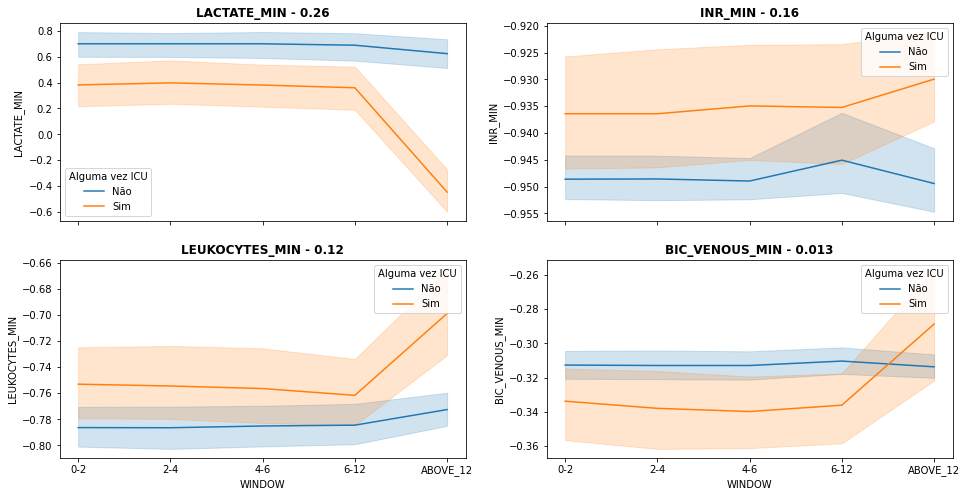

In [22]:
plota_graficos_correlacao('LACTATE_MIN', 0.26, 'INR_MIN', 0.16, 
                          'LEUKOCYTES_MIN', 0.12, 'BIC_VENOUS_MIN', 0.013,
                         'ICU_EVER', dados_limpos)

<font color='blue'> >> </font>Na figura acima notamos como o resultado correlação de *spearman* pode ser aplicado para selecionar variáveis capazes de separar os grupos de pacientes que foram ou não para a UTI. Ao comparar a primeira figura (`LACTATE_MIN` - corr **0.26**), notamos como essa variável separa muito bem os grupos de pacientes que foram ou não pra UTI. Por outro lado, isso não se repete ao trabalharmos com uma variável como `BIC_VENOUS_MIN` que teve uma correlação de apenas **0.013**. <br>


#### Comparação com outros estudos

Recentemente, um estudo publicado na revista Nature apontou que os indicadores lactato, ureia, PCR e creatinina são importantes para diferenciar casos de COVID-19 moderados dos severos. Neste trabalho, os quatro medidores também mostratram correlação importante com a variável preditora `ICU_EVER` (correlações de ~ 0.27, 0.26, 0.23 e 0.14, respectivamente). <br>

> [A multipurpose machine learning approach to predict COVID-19 negative prognosis in São Paulo, Brazil](https://www.nature.com/articles/s41598-021-82885-y)


#### <font color='blue'> >> </font> Desta forma, decidi remover variáveis com correlação menor ou igual a 0.12

In [23]:
cor_todas = dados_limpos[[*cor_unica, 'ICU_EVER']].corrwith(dados_limpos['ICU_EVER'], method='spearman').abs().sort_values(ascending=False)
cor_menor = cor_todas[cor_todas <= 0.12].index

#### Removendo variáveis após decisão:
***
1. Por serem repetidas (var_descartadas);
2. Por terem baixa correlação ou capacidade de diferenciar os grupos de pacientes (cor_menor).

Gerando novas versões dos dados após remoção das variáveis

In [24]:
limitados = dados_limitados.copy()
limitados = limitados.drop([*var_descartadas, *cor_menor], axis=1)
maximizados = dados_maximizados.copy()
maximizados = maximizados.drop([*var_descartadas, *cor_menor], axis=1)

#### Modificiando a variável `AGE_PERCENTIL`
***
Modelos de Machine Learning não se dão muito bem com variáveis do tipo string. Desta forma, modifiquei a variável `age`, transformando-a em números.

In [25]:
limitados.AGE_PERCENTIL = limitados.AGE_PERCENTIL.astype('category').cat.codes
maximizados.AGE_PERCENTIL = maximizados.AGE_PERCENTIL.astype('category').cat.codes

## Modelos
*** 
Existem diversos modelos adequados para estratégias de classificação. Uma estratégia interessante seria avaliar quais modelos performam melhor em avaliar nossos dados e depois seguir modificando os parâmetros do modelo escolhido com o objetivo de obter os melhores resultados possíveis.
***
Nesta estapa, **testarei os seguintes modelos**:
1. LogisticRegression;
2. DecisionTreeClassifier;
3. RandomForestClassifier;
4. GradientBoosting.

<br> 
Além desses, usarei também o DummyRegressor para comparação. <br> 

***
A **avaliação de cada um dos modelos será feita através do resultado da métrica AUC** (*Area Under the ROC Curve*), recomendada para avaliar a relação entre falsos positivos e falsos negativos. <br>
De forma bastante simplista, um modelo que erre 100% das vezes, terá um `AUC = 0.0`, enquanto um modelo que acerte 100% das vezes terá um `AUC = 1`.

### <font color='red'> >> </font> Modelos usando apenas a primeira informação de cada paciente
***
A partir desse ponto, já executamos várias etapas de limpeza dos dados:
1. Removemos pacientes que foram à UTI na primeira janela;
2. Excluímos alguns pacientes que apresentavam dados nulos em janelas anteriores à entrada na UTI;
3. Removemos variáveis redundates;
4. Selecionamos um conjunto de variáveis para treinar o modelo, levando em conta a correlação com ida ou não do para a UTI em algum momento.
**Assim, agora daremos início a triagem de modelos classificatórios utilizando apenas a primeira janela de cada paciente**

#### Triagem de modelos classificatórios
***
Os dados apenas da primeira janela de cada paciente foram separados aleatoriamente em treino e teste, mantendo a mesma propporção de pacientes que foram ou não foram para a UTI nos dois conjuntos, e avaliados perante a AUC (*area under the roc curve*) obtida. Esse processo foi repetido 50 vezes.

In [26]:
analise_modelos = roda_modelos_selecao_unica(limitados, 50)
analise_modelos

,Modelo,AUC_Mean50,IC_Min50,IC_Max50
0,RandomForestClassifier,0.764551,0.646989,0.882113
1,GradientBoostingClassifier,0.744247,0.648891,0.839603
2,LogisticRegression,0.731651,0.644821,0.818480
3,DecisionTreeClassifier,0.599599,0.494276,0.704923
4,DummyRegressor,0.494407,0.360927,0.627887


Aqui testamos 4 modelos classificatórios mais o *DummyRegressor* (que serve como parâmetro de aleatoriedade) e podemos avalia-los perante a AUC resultante, após 50 testes. <br>
<font color='blue'> >> </font> Com base nos resultados obtidos com a AUC média e o intervalo de confiança da AUC em 50 testes realizados, notamos que os modelos **GradientBoostingClassifier, RandomForestClassifier e LogisticRegression** se mostram bastante próximos, com scores médios de ~0.74.

### <font color='red'> >> </font> Existe alta correlação entre as variáveis selecionadas?
***
A presença de variáveis com alta correlação pode atrapalhar o modelo a entender o que realmente importa no desfecho do paciente. <br>
Decidi excluir variáveis que tinha correlação maior do que 0.9 com outras variáveis selecionadas. A escolha desse ponto de corte foi baseada no seguinte artigo:
> [A multipurpose machine learning approach to predict COVID-19 negative prognosis in São Paulo, Brazil](https://www.nature.com/articles/s41598-021-82885-y)


In [27]:
matrix_corr = limitados.iloc[:,4:-2].corr().abs()
matrix_corr.shape

matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k =1).astype(np.bool))
alta_corr = 0.9
excluir = [coluna for coluna in  matrix_upper.columns if any(matrix_upper[coluna] > alta_corr)]
excluir

['HEMOGLOBIN_MIN', 'NEUTROPHILES_MIN']

Modificando os dataframes após remoção das variáveis

In [28]:
limitados = remove_corr_var(limitados, 0.9)
maximizados = maximizados.drop(['HEMOGLOBIN_MIN', 'NEUTROPHILES_MIN'], axis=1)

Testando a performance do modelo com os novos dados

In [29]:
analise_modelos_apos_remocao = roda_modelos_selecao_unica(limitados, 50)
analise_modelos_apos_remocao

,Modelo,AUC_Mean50,IC_Min50,IC_Max50
0,RandomForestClassifier,0.758942,0.662208,0.855677
1,GradientBoostingClassifier,0.730609,0.635492,0.825726
2,LogisticRegression,0.729744,0.621663,0.837824
3,DecisionTreeClassifier,0.589071,0.468519,0.709622
4,DummyRegressor,0.509054,0.404517,0.613592


### Comparação dos scores

In [30]:
comparacao = pd.DataFrame()
comparacao['Modelo'] = analise_modelos_apos_remocao['Modelo']
comparacao['Diff_AUC'] = analise_modelos_apos_remocao['AUC_Mean50']
comparacao['Diff_AUC'] = analise_modelos_apos_remocao['AUC_Mean50'] - analise_modelos['AUC_Mean50']
comparacao['Diff_ICMin'] = analise_modelos_apos_remocao['IC_Min50'] - analise_modelos['IC_Min50']
comparacao['Diff_ICMax'] = analise_modelos_apos_remocao['IC_Max50'] - analise_modelos['IC_Max50']
comparacao

,Modelo,Diff_AUC,Diff_ICMin,Diff_ICMax
0,RandomForestClassifier,-0.005609,0.015218,-0.026436
1,GradientBoostingClassifier,-0.013638,-0.013399,-0.013877
2,LogisticRegression,-0.001907,-0.023158,0.019344
3,DecisionTreeClassifier,-0.010529,-0.025757,0.004699
4,DummyRegressor,0.014647,0.043590,-0.014295


<font color='blue'> >> </font>Notamos que houveram pequenas diferenças na eficácia dos modelos. Ainda assim, a **exclusão de variávéis altamente correlacionadas é uma boa prática**.

### <font color='red'> >> </font> Será que o desbalanço nas classes de pacientes pode estar influenciando no resultado dos modelos?
***
Como visto no código abaixo, temos 84 pacientes a mais na classe dos que nunca irão para a UTI. Um modo de avaliarmos se o desbalanço pode influenciar na performance dos modelos é através de uma remoção aleatória de pacientes do grupo que nunca foi para a UTI e re-testagem do modelo.

In [31]:
limitados.ICU.value_counts()

0    189
1    105
Name: ICU, dtype: int64

Aqui eu removo 84 pacientes que nunca foram para a UTI e realizo os 50 testes novamente.

In [32]:
from random import sample

Para fazer isso, usei a função `roda_modelos_selecao_unica_aleatoria()` que remove de forma aleatória 84 pacientes que nunca foram para a UTI, forçando o balanceamento das classes.

In [33]:
analise_modelos_undersampling = roda_modelos_selecao_unica_aleatoria(limitados, 50)
analise_modelos_undersampling

,Modelo,AUC_Mean50,IC_Min50,IC_Max50
0,LogisticRegression,0.774103,0.685914,0.862291
1,RandomForestClassifier,0.768291,0.655497,0.881084
2,GradientBoostingClassifier,0.745470,0.630108,0.860832
3,DecisionTreeClassifier,0.599444,0.447295,0.751594
4,DummyRegressor,0.502265,0.360435,0.644095


Comparando com os resultados anteriores

In [34]:
comparacao_undersampling = pd.DataFrame()
comparacao_undersampling['Modelo'] = analise_modelos_apos_remocao['Modelo']
comparacao_undersampling['Diff_AUC'] = analise_modelos_apos_remocao['AUC_Mean50'] - analise_modelos_undersampling['AUC_Mean50']
comparacao_undersampling['Diff_ICMin'] = analise_modelos_apos_remocao['IC_Min50'] - analise_modelos_undersampling['IC_Min50']
comparacao_undersampling['Diff_ICMax'] = analise_modelos_apos_remocao['IC_Max50'] - analise_modelos_undersampling['IC_Max50']
comparacao_undersampling

,Modelo,Diff_AUC,Diff_ICMin,Diff_ICMax
0,RandomForestClassifier,-0.015160,-0.023706,-0.006614
1,GradientBoostingClassifier,-0.037682,-0.020005,-0.055358
2,LogisticRegression,-0.015726,-0.008444,-0.023009
3,DecisionTreeClassifier,-0.010374,0.021224,-0.041972
4,DummyRegressor,0.006790,0.044082,-0.030503


<font color='blue'> >> </font>Após essa análise, notei **certa influêcia do número de representantes de cada classe** na eficácia dos modelos. Ainda asim, os três melhores modelos anteriores continuam no topo, com certa troca de lugares no podium. <br>
**Importante**, o resultado dessa influência varia de acordo com os pacientes removidos aleatoriamente. Métodos de *undersampling* mais refinados possivelmente produziriam resultados melhores! <br>
**Por exemplo**:
* Remover pacientes do grupo 0 que possuem valores mais próximos dos do grupo 1 - produziria um modelo capaz de discernir melhor os pacientes que apresentam discrepâncias mais claras;
* Remover pacientes do grupo 0 que possuem valores muito distantes dos do grupo 1 - produziria um modelo que poderia ser capaz de diferenciar casos em que os dados são muito parecidos entre os pacientes;
***
#### <font color='blue'> >> </font> Decidi continuar com os dados desbalanceados

**Obs:** Não ser capaz de realizar esse undersampling de forma mais robusta, é uma **limitação do meu trabalho!**

## Cross Validation
***
As técnicas de validação cruzada são mais uma estratégia para fortalecer os resultados encontrados ao treinar e testar modelos de *machine learning*. Existem diversas [estratégas](https://scikit-learn.org/stable/modules/cross_validation.html) que podem ser aplicadas, com diferentes recomendações e limitações. <br>
Uma das estratégias mais utilizadas é realizar uma série de fragmentações e testes no seu banco de dados. Assim garantimos que o modelo seja treinado e testado com todos os dados, afim de obter métricas adequadas. <br>
Para o nosso caso, em que temos poucas amostras e também um desbalanço entre as classes de amostras (`ICU 0 ou 1`), uma das estratégias interessantes é o `RepeatedStratifiedKFold`. <Br>
Esse método permite separarmos nossos dados em um certo número de partes (`n_splits`) e repetir os processos um certo número de vezes (`n_repeats`), sempre mantendo a estratificação da nossa variável de predição. Ou seja, **garantimos uma repetição com aleatoriedade consistente, mantendo a mesma proporção das classes** nas amostras de treino e teste.
    

In [35]:
modelo_random_forest =  RandomForestClassifier(n_estimators=100)
modelo_gradient_boost = GradientBoostingClassifier(n_estimators=100)
modelo_logit = LogisticRegression()

In [36]:
roda_cross_validate_modelos([modelo_random_forest, modelo_gradient_boost, modelo_logit], limitados,
                           5, 10)

,Modelo,AUC_Mean,IC_Min,IC_Max
0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.761878,0.646132,0.877624
1,"GradientBoostingClassifier(ccp_alpha=0.0, crit...",0.744523,0.625127,0.863920
2,"LogisticRegression(C=1.0, class_weight=None, d...",0.747083,0.631208,0.862957


Aqui notamos como existe sim uma variação importante entre a AUC dos três modelos ao fazer a validação cruzada. Desta forma podemos ter uma noção real dos limites dos modelos com base no intervalo de confiança obitido. Apesar de performarem muito bem em certas situações, podem ter resultados insatisfatórios em outras situações. <br>
<font color='blue'> >> </font> Com base nesses resultados, decidi escolher o modelo `RandomForestClassifier`para continuar as análises.

### <font color='red'> >> </font> É possível melhorar esses resultados? - Hyperparameter Tuning
Uma maneira de melhorar a eficácia de um modelo é através da melhora dos hiperparâmetros (*hyperparameter tunning*). Através de métodos como o `GridSearchCV` ou `RandomizedSearchCV`, podemos testar a performance de um modelo com diferentes parâmetros e selecionar os que melhor se adequam aos nossos dados. <br>
Neste caso, vamos realizar os processos de teste dos hiperparâmetros usando apenas um conjunto de treino dos dados. Em seguida, testaremos a performance desse modelo perante os dados de teste deixados de lado.<br>
***
**Obs**: Procurando em algumas fontes vi que uma estratégia mais sólida seria separar o conjunto de dados em 3 partes:
* Treino -> Usada para treinar os modelos;
* Teste  -> Usada para testar as versões finais do modelo;
* Validação -> Fração utilizada para determinar a performance dos modelos após seleção de hiperparâmetros.

Como temos um número bastante limitado de dados para treinar os modelos, decidi não fragmentar os dados em 3 partes. **Esta pode ser mais uma limitação do meu trabalho.**

Separando os dados que serão utilizados para os próximos passos

In [37]:
X, y = limitados.drop(['WINDOW','ICU', 'PATIENT_VISIT_IDENTIFIER'], axis=1), limitados['ICU']
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y)

De forma geral, o modelo RandomForest é mais lento para ser treinado. Assim, usarei o método `RandomizedSearchCV` para buscar por combinações satisfatórias dentro de um espaço de possibilidades. Esse método é especialmente útil quando trabalhamos com bancos de dados com muitas linhas.

In [38]:
# Número de árvores
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Número de features para cada 'split'
max_features = ['auto', 'sqrt']
# Número máximo de folhas em cada árvore
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Número mínimo de amostras para separar um nó
min_samples_split = [2, 5, 10]
# Número mínimo de amostras por nó nas folhas
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

Instanciando o modelo

In [39]:
modelo_random_forest = RandomForestClassifier()

In [40]:
rf_random = RandomizedSearchCV(estimator = modelo_random_forest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,
                               return_train_score=True)

In [41]:
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [42]:
print(f'Train score : {rf_random.score(x_train, y_train):.3f}')
print(f'Test score : {rf_random.score(x_test, y_test):.3f}')

Train score : 0.986
Test score : 0.757


In [43]:
modelo_random_forest_param = rf_random.best_estimator_

In [44]:
modelo_random_forest_param

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Para comparar os resultados obitidos, vamos realizar a validação cruzada do modelo "bruto" contra o modelo otimizado com o `RandomizedSearchCV`

In [45]:
modelos = [modelo_random_forest, modelo_random_forest_param]
df_comparacao_parametros = roda_cross_validate_modelos(modelos, limitados, 5, 10)

In [46]:
df_comparacao_parametros

,Modelo,AUC_Mean,IC_Min,IC_Max
0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.761878,0.646132,0.877624
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.765115,0.649363,0.880868


No dataframe acima, temos a comparação entre o modelo "bruto" e o modelo após a seleção de hiperparâmetros, frente a uma validação cruzada com 5 *folds* e 10 repetições.
***
Após a tentativa de otimização dos parâmetros, notei que houve pequena mudança na eficácia dos modelos. <br>
Isso pode ter acontecido por algumas razões: 
1. Foi **encontrado um limite de eficácia**, considerando esses modelos e os dados disponíveis;
2. **Que eu não realizei uma busca exaustiva dos melhores parâmetros**.
***
Ainda assim, o modelo que teve o melhor resultado foi o **RandomForest** após otimizações. 

### <font color='red'> >> </font> Otimização secundária do melhor modelo
Partindo do melhor modelo selecionado anteriormente, tentarei fazer uma nova otimização, desta vez usando o `GridSearchCV`, focando nos parâmetros `max_depth` e `n_estimators`.

In [47]:
max_depth_range = np.arange(20,25,1)
n_estimators_range = np.arange(2000, 3000, 200)
param_grid = dict(max_depth=max_depth_range, n_estimators=n_estimators_range)

In [48]:
grid = GridSearchCV(estimator = modelo_random_forest_param, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1,
                   scoring='roc_auc')

In [49]:
grid.fit(x_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  3.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=60,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=2,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=2000, n_jobs=None,
                                              oob_score=False,
                                              rand

In [50]:
modelo_random_forest_param_extra = grid.best_estimator_
modelo_random_forest_param_extra

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=21, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
modelos = [modelo_random_forest, modelo_random_forest_param, modelo_random_forest_param_extra]
df_comparacao_parametros = roda_cross_validate_modelos(modelos, limitados, 5, 10)
df_comparacao_parametros

,Modelo,AUC_Mean,IC_Min,IC_Max
0,"RandomForestClassifier(bootstrap=True, ccp_alp...",0.761878,0.646132,0.877624
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.765115,0.649363,0.880868
2,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.757152,0.638356,0.875947


Aqui notamos que houve melhora "significativa" na AUC do modelo após as primeiras otimizações. Porém, a otimização seguinte nos trouxe uma melhora bastante sútil. <br>
Aparentemente, isso reforça a teoria de que o modelo chegou a um limite de performance, dado os dados disponíveis.

### Visualizando o processo de otimização do novo modelo
***
Muitas vezes o processo de treinamento e obtenção das métricas pode parecer algo "mágico". Dessa forma, plotei algumas gráficos para avaliarmos a performance do modelo, à medida que são executados testados diferentes parâmetros. <br>
**Obs**: Os resultados são baseados apenas no conjunto de treino.

In [52]:
grid_results = pd.concat([pd.DataFrame(grid.cv_results_['params']), pd.DataFrame(grid.cv_results_['mean_test_score'], columns=['AUC'])], axis=1)
grid_contour = grid_results.groupby(['max_depth','n_estimators']).mean()

grid_reset = grid_contour.reset_index()
grid_reset.columns = ['max_depth', 'n_estimators', 'AUC']
grid_pivot = grid_reset.pivot('max_depth', 'n_estimators')

x = grid_pivot.columns.levels[1].values
y = grid_pivot.index.values
z = grid_pivot.values

In [53]:
import plotly.graph_objects as go

# X and Y axes labels
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_depth') 
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Efeito de n_estimators e max_depth na AUC do modelo RandomForest', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

Na figura acima temos um mapa de calor 2D. De forma simples, as regiões com cores mais próximas do amarelo indicam combinados de n_estimators e max_features que mostram os melhores resultados de AUC. 

In [54]:
import plotly.graph_objects as go


fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Efeito de n_estimators e max_depth na AUC do modelo RandomForest',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_depth',
                    zaxis_title='AUC'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

Por outro lado, nessa versão 3D da figura acima, conseguimos notar o comportamento da AUC através dos vários testes feitos pelo GridSearcCV

## O melhor modelo obtido foi

In [55]:
grid.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=21, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Extra

## <font color='red'> >> </font> Pacientes fictícios
***
Uma das limitações que temos com o banco de dados do desafio é a **quantidade limitada de pacientes** para treinamento de um modelo preditivo, **especialmente quanto aos pacientes que foram para a UTI**. Uma estratégia que é utilizada em situações como essas é a de gerar dados fictícios. <br>
<font color='gray'> >> </font> Neste caso, **gerarei 2 versões para cada paciente** contendo valores máximos e mínimos de cada variável. <br>
Pensei em trabalhar desta forma pois **poderíamos preparar o modelo para lidar com pacientes diferentes**, já que **não há garantia de que todos os pacientes cheguem ao hospital em estados parecidos**. Adicionalmente, com essa estratégia eu considero cada entrada como um paciente diferente e treino o modelo com esses dados.

**Tabela 6. Pacientes fictícios gerados a partir de valores máximos e mínimos de cada paciente real.**

| **Paciente** | **Janela** | **Exame_A** | **ICU** | **ICU_EVER** | --> | **Paciente** | **Exame_A** | **ICU_EVER** |
|:------------:|:----------:|:-----------:|:-------:|:------------:|:---:|:------------:|:-----------:|:------------:|
|       A      |     0-2    |      5      |    0    |       1      | --> |   **A_min**  |      3      |       1      |
|       A      |     2-4    |      4      |    0    |       1      | --> |   **A_max**  |      5      |       1      |
|       A      |     4-8    |      3      |    1    |       1      | --> |       x      |      x      |       x      |
|       B      |     0-2    |      2      |    0    |       1      | --> |   **B_min**  |      1      |       1      |
|       B      |     2-4    |      1      |    1    |       1      | --> |   **B_max**  |      2      |       1      |

Assim, cada paciente foi transformado em 2, contendo dados máximos e mínimos. Esses dois novos pacientes carregam a informação da variável `ICU_EVER`, classificando-os independentemente da janela. Tomei a decisão de **gerar apenas 2 pacientes** pois alguns pacientes tem **poucas janelas para extração de dados**. 
***
**Obs:** Existem modos mais sofisticados para gerar dados fictícios. Aqui tentei uma maneira bastante simplista como exercício.

In [56]:
dados_max_min = gera_max_min(maximizados)
dados_max_min

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MIN,BE_ARTERIAL_MIN,BE_VENOUS_MIN,BLAST_MIN,CALCIUM_MIN,CREATININ_MIN,GGT_MIN,GLUCOSE_MIN,HEMATOCRITE_MIN,INR_MIN,LACTATE_MIN,LEUKOCYTES_MIN,LINFOCITOS_MIN,PCR_MIN,PH_ARTERIAL_MIN,SODIUM_MIN,UREA_MIN,DIMER_MIN,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_EVER
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-1.0,0.183673,-0.868365,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.875236,0.234043,-0.028571,-0.836145,-0.994912,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1,1
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-1.0,0.183673,-0.868365,-0.945093,-0.891993,0.090147,-0.932246,1.000000,-0.835844,-0.914938,-0.875236,0.234043,-0.028571,-0.836145,-0.994912,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-1.0,0.357143,-0.912243,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.939887,0.234043,0.085714,-0.836145,-0.978029,-0.658863,-0.563758,-0.747001,-0.926882,-1.000000,-0.961262,0-2,0,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-1.0,0.357143,-0.912243,-0.958528,-0.780261,0.144654,-0.959849,1.000000,-0.382773,-0.908714,-0.939887,0.234043,0.085714,-0.836145,-0.978029,-0.515528,-0.351328,-0.721834,-0.756272,-1.000000,-0.801293,6-12,1,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.000000,-1.0,0.326531,-0.968861,-0.316589,-0.891993,-0.203354,-0.959849,-0.828421,-0.729239,-0.836100,-0.503592,0.234043,0.200000,-0.937349,-0.978029,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,ABOVE_12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,382,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-1.0,0.357143,-0.905166,-0.958528,-0.891993,0.064990,-0.957340,1.000000,-0.718038,-0.821577,-0.034405,0.234043,-0.085714,-0.787952,-0.964461,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,1,1
292,383,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.210526,-1.0,-1.000000,-1.0,0.357143,-0.947629,-0.958528,-0.891993,-0.203354,-0.959849,1.000000,-0.877559,-0.819502,-0.868809,0.234043,0.066667,-0.937349,-0.978029,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,0
292,383,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.000000,-1.0,0.357143,-0.922151,-0.713785,-0.843575,-0.069182,-0.959849,1.000000,-0.758208,-0.690871,-0.804159,0.234043,0.085714,-0.932530,-0.978029,-0.552795,-0.585967,-0.557252,-0.573477,-0.572609,-0.838524,ABOVE_12,0,0
293,384,0,4,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-0.717277,-1.0,0.306122,-0.934890,-0.960280,-0.862197,-0.064990,-0.957340,1.000000,-0.848590,-0.634855,-0.801134,0.234043,0.200000,-0.807229,-0.888448,-0.701863,-0.585967,-0.763868,-0.612903,-0.551337,-0.835052,ABOVE_12,0,0


Avaliando a perfomance do melhor modelo selecionado anteriormente perante o dataframe gerado (`dados_max_min`).

In [57]:
roda_cross_validate_modelos_min_max([modelo_random_forest_param_extra], dados_max_min, 5, 10)

,Modelo,AUC_Mean,IC_Min,IC_Max
0,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.978805,0.956801,1.000809


Aqui notamos uma melhor significativa na AUC quando comparada aos modelos anteriores, treinados usando apenas os dados da primeira janela de cada paciente. <br>
Na verdade, **não podemos confiar nos resultados obitidos aqui**. Possivelmente, <font color='red'>versões max e min do mesmo paciente foram usadas para teste e treino </font>. Apesar de teoricamente considerarmos cada entrada como um paciente diferente, ainda existe forte relação entre essas versões.
***
Para avaliar a performance desse modelo temos alguns problemas:
* Não existe um método que faça a separação dos dados de treino e teste considerando alguns grupos (em nosso caso, os pacientes) e de forma estratificada.
* Apesar do método de cross-validation `GroupKFold()` ser capaz de garantir que não haverá dados do mesmo grupo nos conjuntos de treino e teste, ele não é capaz de trabalhar de forma a estratificar a variável y.

<br>

Assim, desenvolvi uma série de funções (chamadas pela função `testa_n_vezes_max_min()`) que:

1. Gera o dataframe com as versões max e min de cada paciente restante;
2. Seleciona uma proporção dos pacientes que tem ICU = 1 para usar como teste;
3. Usa a mesma proporção para selecionar os pacientes com ICU = 0 para teste;
4. Treina o melhor modelo RandomForest um determinado número de vezes e retorna os valores médios das métricas observadas.


In [58]:
from random import sample

testa_n_vezes_max_min(50, 5)

,AUC_Média50,Recall_Médio50,F1_Médio50,Precision_Médio50
0,0.953584,0.77381,0.836016,0.891724


Esses resultados são referentes a um modelo treinado com 80% dos pacientes fictícios (3 versões), e testada com 20% dos pacientes fictícios restantes. O processo foi repetido 50 vezes, garantindo aleatoriedade na seleção dos pacientes e mantendo a estratificação. <br>
<font color='blue'> >> </font> Chegamos então a um modelo eficaz, sendo treinado e testado usando os pacientes fictícios gerados.
### <font color='red'> >> </font> E esse modelo seria eficaz em prever o desfecho de pacientes reais?

,AUC_Média50,Recall_Médio50,F1_Médio50,Precision_Médio50
0,0.735109,0.778095,0.617051,0.651034


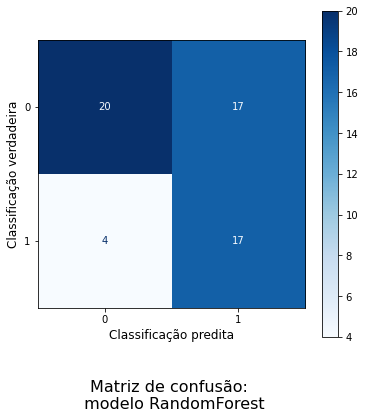

In [59]:
testa_n_vezes_max_min_reais(50, 5)

Aqui utilizei o modelo RandomForest treinado com os *dados_max_min* com os melhores parâmetros encontrados na etapa de *Hyperparameter tuning*, para prever dados de pacientes reais deixados de fora do treino. <br>
Considerando o foco do desafio, a previsão foi feita apenas em cima da primeira janela (0-2), com o intuito de agilizar o diagnóstico e preparo da equipe hospitalar.
**Como resultado**:
* Esse modelo atingiu uma AUC mais baixa do que os treinados usando dados reais da janela 0-2 de cada paciente;
* Infelizmente, notamos qe o Recall se mostra razoavelmente baixo, indicando a presença de falsos negativos, o que é extremamente prejudicial em situações emergênciais como essa;
* Além disso, a própria precisão não se mostrou tão alta.


# Conclusões e limitações
1. Trabalhar com dados reais, considerando uma situação emergencial como a dos pacientes internados com COVID-19 é algo muito complexo:

Considerando que a vida de um ser humano está em risco, deve-se tratar o processo de geração do modelo com a maior seriedade possível. 

2. A qualidade dos dados influencia muito nos possíveis resultados:

Todas as etapas do fluxo de vida dos dados são muito importantes nesses casos. "Desenho experimental", coleta padronizada, normalização, armazenamento e análise.

3. O meu conhecimento perante aos modelos de machine learning, bem como a teoria e a matemática por trás do código foi um grande fator limitante no meu projeto;
4. Parte das condutas que tomei foram "simples demais" para resolver problemas complexos: undersampling, geração de pacientes fictícios e etc;
